# Models/LSTM Preprocess - In Progress

In [1]:
import pandas as pd

In [2]:
sentiment = pd.read_csv("/content/sentiment.csv", index_col=[0,1])

In [3]:
fin_data = pd.read_csv("/content/processed_fin_data.csv", index_col=[0,1])

In [4]:
sentiment

Sentiment
Symbol Date                
A      Apr-05-24   0.999963
       Apr-04-24   0.999681
       Apr-03-24   0.999998
       Apr-02-24   0.500000
       Apr-01-24   0.999990
...                     ...
ZTS    Sep-15-23   0.000000
       Sep-13-23   0.000000
       Sep-12-23   0.499582
       Sep-09-23   0.000000
       Sep-07-23  -0.999245

[26592 rows x 1 columns]

In [5]:
combined_data = pd.concat([fin_data[["Close"]], sentiment], axis=1).dropna()

In [6]:
combined_data.reset_index()["Symbol"].value_counts()

,count
Symbol,
APA,86
CTRA,81
AEP,79
J,79
EVRG,78
...,...
DIS,3
GOOG,3
NVDA,3


<Axes: >

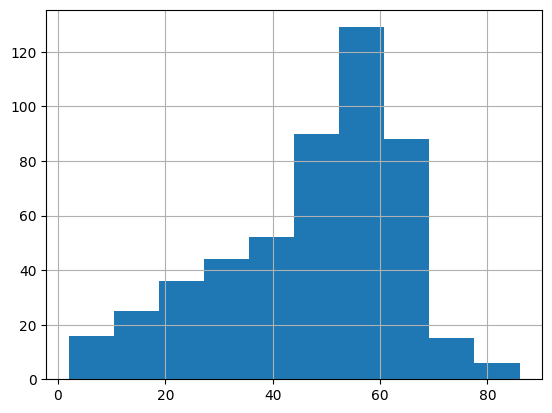

In [7]:
(combined_data.reset_index()["Symbol"].value_counts()).hist()

In [8]:
greater_than_30_entries = [i for i in (combined_data.reset_index()["Symbol"].value_counts() > 30).index if (combined_data.reset_index()["Symbol"].value_counts() > 30)[i]]

In [9]:
combined_data = combined_data.reset_index()[(combined_data.reset_index()["Symbol"]).isin(greater_than_30_entries)]

In [11]:
sector_data = pd.read_csv("sector_data.csv")

In [12]:
sector_data = sector_data.sort_values(by="Symbol")

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
sector_data.loc[:,"GICS Sector"] = encoder.fit_transform(sector_data.loc[:,"GICS Sector"])

In [14]:
sector_data = sector_data.set_index("Symbol")
sector_data

,GICS Sector
Symbol,
A,5
AAL,6
AAPL,7
ABBV,5
ABNB,1
...,...
XYL,6
YUM,1
ZBH,5


In [15]:
encoder.inverse_transform(range(11))

array(['Communication Services', 'Consumer Discretionary',
       'Consumer Staples', 'Energy', 'Financials', 'Health Care',
       'Industrials', 'Information Technology', 'Materials',
       'Real Estate', 'Utilities'], dtype=object)

In [16]:
combined_data = combined_data[~combined_data["Symbol"].isin(['VFC', 'XRAY'])]

In [17]:
combined_data['Sector'] = sector_data.loc[combined_data['Symbol']].values.flatten()

In [18]:
combined_data = combined_data.sort_values(by=["Sector", "Symbol"]).set_index("Symbol")

In [19]:
def normalization():
  count = 0
  group_by = combined_data.groupby(by=["Symbol"])
  df = pd.DataFrame(columns=["Symbol", "Max", "Min"])
  # print(group_by.count())
  for symbol in combined_data.index.unique():
    max = group_by.max()["Close"].loc[symbol]
    min = group_by.min()["Close"].loc[symbol]
    print(symbol, max, min)
    df.loc[count] = [symbol, max, min]
    x_std = (combined_data.loc[symbol, 'Close'] - min) / (max - min)
    x_scaled = x_std * (max - min) + min
    combined_data.loc[symbol, "Normalized"] = x_std
    count += 1
  return df

In [20]:
normalization_key = normalization()

CHTR 414.8399963378906 275.69000244140625
EA 143.0800018310547 122.62999725341795
FOX 29.799999237060547 26.31999969482422
FOXA 31.6200008392334 28.780000686645508
IPG 33.27000045776367 27.559999465942383
LYV 105.7699966430664 78.0999984741211
MTCH 39.040000915527344 33.290000915527344
NWS 27.989999771118164 20.950000762939453
NWSA 26.8799991607666 20.450000762939453
OMC 95.66999816894533 73.30000305175781
TMUS 167.4199981689453 160.61000061035156
TTWO 169.60000610351562 143.89999389648438
APTV 103.16000366210938 75.2699966430664
AZO 3239.320068359375 2436.1201171875
BBWI 50.02000045776367 28.690000534057617
BBY 81.66000366210938 68.02999877929688
BWA 41.18000030517578 30.170000076293945
CZR 49.15999984741211 40.9900016784668
DECK 952.9400024414062 754.1500244140625
DHI 164.5500030517578 139.2100067138672
DPZ 496.8800048828125 346.8099975585937
DRI 174.5800018310547 157.1300048828125
EBAY 52.77999877929688 41.06999969482422
ETSY 78.8499984741211 64.9800033569336
GPC 168.07000732421875 

In [21]:
normalized_data = combined_data[["Sentiment", "Sector", "Normalized"]].reset_index()

In [22]:
import numpy as np

In [25]:
def batching():
  train_symbols = []
  test_symbols = []
  X_train, X_test = [], []
  y_train, y_test = [], []
  for symbol in normalized_data["Symbol"].unique():
    temp_df = normalized_data[normalized_data["Symbol"] == symbol]
    data = np.array(temp_df[["Sentiment", "Normalized", "Sector"]])
    split = int(0.8 * data.shape[0])
    counter = 0
    for i in range (10, data.shape[0]):
      if counter < split:
        X_train.append(data[i-10:i, :])
        y_train.append(data[i, 1])
        train_symbols.append(symbol)
      else:
        X_test.append(data[i-10:i, :])
        y_test.append(data[i, 1])
        test_symbols.append(symbol)
      counter +=1

  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), train_symbols, test_symbols

In [26]:
X_train, X_test, y_train, y_test, train_symbols, test_symbols = batching()

In [27]:
X_train.shape

(17086, 10, 3)

In [28]:
X_test.shape

(637, 10, 3)

In [29]:
y_train.shape

(17086,)

In [30]:
y_test.shape

(637,)

In [31]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional

In [32]:
X_train.shape[1:]

(10, 3)

In [33]:
model = Sequential()

model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:])))
model.add(Dropout(rate=0.2))
model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
model.add(Dropout(rate=0.5))
model.add(Bidirectional(LSTM(units=20, return_sequences=True)))
model.add(Dropout(rate=0.5))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=40))
model.add(Dense(units=1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


'\nmodel = Sequential()\n\nmodel.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:])))\nmodel.add(Dropout(rate=0.2))\nmodel.add(Bidirectional(LSTM(units=20, return_sequences=True)))\nmodel.add(Dropout(rate=0.5))\nmodel.add(Bidirectional(LSTM(units=20, return_sequences=True)))\nmodel.add(Dropout(rate=0.5))\nmodel.add(Bidirectional(LSTM(units=50)))\nmodel.add(Dense(units=40))\nmodel.add(Dense(units=1, activation="sigmoid"))\n\n40\n\n\nmodel.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))\nmodel.add(Dropout(rate=0.2))\nmodel.add(LSTM(units=20, return_sequences=True))\nmodel.add(Dropout(rate=0.2))\nmodel.add(LSTM(units=20, return_sequences=True))\nmodel.add(LSTM(units=50))\n# model.add(Dropout(rate=0.2))\nmodel.add(Dense(units=20))\nmodel.add(Dense(units=1, activation="sigmoid"))\n\n20 epochs\n\nmodel.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))\nmodel.add(Dropout(rate=0.2))\nmodel.add(LSTM(units=20, 

In [34]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [35]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [36]:
X_train.shape

(17086, 10, 3)

In [37]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.1706 - val_loss: 0.1195
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0973 - val_loss: 0.0920
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0912 - val_loss: 0.0872
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0860 - val_loss: 0.0916
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0844 - val_loss: 0.0875
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0804 - val_loss: 0.0809
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0811 - val_loss: 0.0794
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0785 - val_loss: 0.0882
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0784 - val_loss: 0.0832
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0761 - val_loss: 0.0780
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0755 - val_loss: 0.0777
Epoch 12/20
214/214 ━━━━━━━━━━━━━━━━━━━━

In [38]:
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [39]:
y_preds = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


In [41]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_preds)
rms = root_mean_squared_error(y_test, y_preds)
mape = mean_absolute_percentage_error(y_test, y_preds)

In [42]:
# accuracy = 1- mape

In [43]:
mae, rms, #mape

(0.06033661589026451, 0.0800967738032341)

In [44]:
y_preds.sum()/y_preds.shape[0]

0.7156637482216445

In [67]:
normalization_key = normalization_key.set_index("Symbol")

In [68]:
normalization_key

,Max,Min
Symbol,,
CHTR,414.839996,275.690002
EA,143.080002,122.629997
FOX,29.799999,26.320000
FOXA,31.620001,28.780001
IPG,33.270000,27.559999
...,...,...
PPL,28.760000,22.549999
SO,73.080002,66.459999
SRE,76.489998,69.349998


In [69]:
# train_symbols

In [70]:
# test_symbols

In [71]:
y_pred_unn = []

In [72]:
y_preds.shape

(637, 1)

In [73]:
for i in range(len(y_preds)):
  max = normalization_key.loc[test_symbols[i], "Max"]
  min = normalization_key.loc[test_symbols[i], "Min"]
  y_pred_unn.append(float(y_preds[i] * (max - min) + min))

<ipython-input-73-587594921f9b>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_unn.append(float(y_preds[i] * (max - min) + min))


In [74]:
len(y_pred_unn)

637

In [75]:
# y_pred_unn

In [76]:
y_test_unn = []

In [77]:
len(y_test)

637

In [78]:
for i in range(len(y_test)):
  max = normalization_key.loc[test_symbols[i], "Max"]
  min = normalization_key.loc[test_symbols[i], "Min"]
  y_test_unn.append(float(y_test[i] * (max - min) + min))

In [79]:
# y_test_unn

In [81]:
mae = mean_absolute_error(y_test_unn, y_pred_unn)
rms = root_mean_squared_error(y_test_unn, y_pred_unn)
mape = mean_absolute_percentage_error(y_test_unn, y_pred_unn)

In [82]:
mae, mape, rms

(3.7652646597023245, 0.016895473263960244, 13.224508936281593)

In [83]:
import matplotlib.pyplot as plt

In [84]:
df = pd.DataFrame(columns=["Symbol", "True", "Preds"])
for i in range (len(test_symbols)):
  df.loc[i] = [test_symbols[i], y_test_unn[i], y_pred_unn[i]]

In [85]:
df = df.set_index("Symbol")

In [86]:
df.index.unique()

Index(['EA', 'IPG', 'NWS', 'OMC', 'APTV', 'BBWI', 'BWA', 'DPZ', 'GPC', 'GRMN',
       ...
       'NI', 'NRG', 'PCG', 'PEG', 'PNW', 'PPL', 'SO', 'SRE', 'WEC', 'XEL'],
      dtype='object', name='Symbol', length=271)

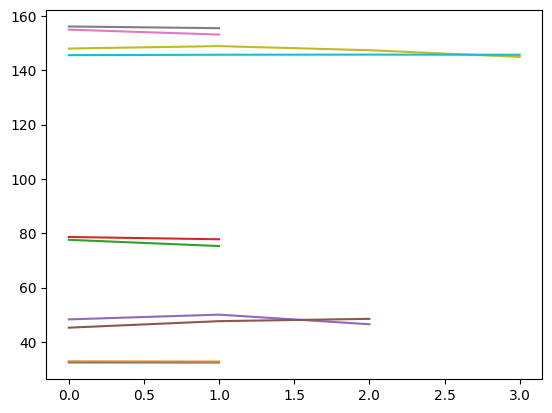

In [122]:
for symbol in df.index.unique()[:10]:#4, 5,
  try:
    len(df.loc[symbol])
    plt.plot(range(len(df.loc[symbol, "True"])), df.loc[symbol, "True"])
    plt.plot(range(len(df.loc[symbol, "Preds"])), df.loc[symbol, "Preds"])
  except:
    pass
plt.show()